In [267]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.optimize import curve_fit

#generate the lattice
def generate_percolation_lattice(size, p):
    lattice = np.random.rand(size, size) < p
    lattice = lattice.astype(int)
    lattice[0, :] = 1
    lattice[-1, :] = 1
    return lattice

# Function to find the root of the component, using path compression
def find(x, parent):
    if parent[x] != x:
        parent[x] = find(parent[x], parent)  # Path compression
    return parent[x]

# Function to union two components
def union(x, y, parent, size):
    root_x = find(x, parent)
    root_y = find(y, parent)
    if root_x != root_y:
        if size[root_x] < size[root_y]:
            parent[root_x] = root_y
            size[root_y] += size[root_x]
        else:
            parent[root_y] = root_x
            size[root_x] += size[root_y]

def hoshen_kopelman(lattice):
    rows, cols = lattice.shape
    labels = np.zeros((rows, cols), dtype=int)
    parent = np.arange(rows * cols + 1)
    size = np.ones(rows * cols + 1)
    next_label = 1
    
    for r in range(rows):
        for c in range(cols):
            if lattice[r, c] == 1:
                # Get neighbor labels
                left = labels[r, c - 1] if c > 0 else 0
                above = labels[r - 1, c] if r > 0 else 0

                if left == 0 and above == 0:
                    # New cluster
                    labels[r, c] = next_label
                    next_label += 1
                elif left != 0 and above == 0:
                    # Part of the left cluster
                    labels[r, c] = find(left, parent)
                elif left == 0 and above != 0:
                    # Part of the above cluster
                    labels[r, c] = find(above, parent)
                else:
                    # Part of both clusters
                    root_left = find(left, parent)
                    root_above = find(above, parent)
                    if root_left != root_above:
                        union(left, above, parent, size)
                    labels[r, c] = find(root_left if left else root_above, parent)

    # Second pass to flatten labels
    unique_labels = set()
    for r in range(rows):
        for c in range(cols):
            if labels[r, c] != 0:
                labels[r, c] = find(labels[r, c], parent)
                unique_labels.add(labels[r, c])

    # Remap labels to make them consecutive
    unique_labels = sorted(unique_labels)
    final_labels = {old: new for new, old in enumerate(unique_labels, start=1)}
    
    for r in range(rows):
        for c in range(cols):
            if labels[r, c] != 0:
                labels[r, c] = final_labels[labels[r, c]]
    
    return labels

# check if there is a spanning clustser (top to bottom only!)
def spanning_check(labels):
    top_labels = np.unique(labels[0])
    bottom_labels = np.unique(labels[-1])
    for label in top_labels:
        if label in bottom_labels and label != 0:
            return True, label
    return False, None

def calculate_mass(lattice, labels, span_label):
    total_sites = lattice.size
    cluster_sites = np.sum(labels == span_label) if span_label else 0
    return cluster_sites / total_sites

def plot_clusters(grid, labels, save=True):
    unique_labels = np.unique(labels)
    num_unique_labels = len(unique_labels)

    if save: fig, ax = plt.subplots(figsize=(5, 5), dpi= 300, facecolor='w', edgecolor='k')
    else: plt.figure(figsize=(8, 8))
    # Create a colormap with as many colors as unique labels
    colors = plt.cm.hsv(np.linspace(0, 1, num_unique_labels))
    color_map = ListedColormap(colors)
    
    # Plot the original grid
    plt.imshow(grid, cmap='gray', interpolation='nearest')
    
    # Overlay clusters with transparency
    for i, label in enumerate(unique_labels):
        if label != 0:
            mask = labels == label
            # Create an overlay with a unique color for the current label
            colored_mask = np.zeros((grid.shape[0], grid.shape[1], 4))
            colored_mask[mask] = colors[i]
            plt.imshow(colored_mask, interpolation='nearest')
    
    plt.title("Random Resistor Network")
    if save:
        plt.savefig("samplelattice.png")
        return
    plt.show()

def gen_and_plot(size, p=0.6, verbose=False):
    lattice = generate_percolation_lattice(size, p)
    labeling = hoshen_kopelman(lattice)
    plot_clusters(lattice, labeling)
    spanning, span_label = spanning_check(labeling)
    if verbose: 
        print("Lattice: ")
        print(lattice)
        print("Labels: ")
        print(labeling)
    if spanning: 
        print("There IS a spanning cluster in the above lattice...")
        mass = calculate_mass(lattice, labeling, span_label)
        print("Mass of the percolating cluster:", mass)
    else: 
        print("There is NOT a spanning cluster in the above lattice...")
        
    return lattice


def CalculatePotential(network, maxiter, tolerance, alpha=0.8, verbose=True): 
    V_c = 1.0  # Define a constant potential
    potential = np.zeros(network.shape)
    size = network.shape[0]
    
    # Initialize the potential as a linear gradient from top to bottom
    for row in np.arange(0, size):
        for column in np.arange(0, size):
            potential[row][column] = V_c * (size - row - 1) / (size - 1)

    numiter = 0
    reachedmax = True
    
    while numiter < maxiter:
        oldpotential = potential.copy()

        for row in np.arange(1, size-1):
            for column in np.arange(0, size):
                # Determine the neighboring column indices with periodic boundary conditions
                column_prev = (column - 1) % size
                column_next = (column + 1) % size
                
                if network[row][column] == 1:
                    sigmaxy = 1
                else:
                    sigmaxy = 0
                
                if network[row + 1][column] == 1:
                    sigmay1 = 1
                else:
                    sigmay1 = 0

                if network[row][column_next] == 1:
                    sigmax1 = 1
                else:
                    sigmax1 = 0

                sumsigma = sigmax1 + sigmay1 + 2 * sigmaxy
                if sumsigma == 0:
                    continue
                
                new_value = (
                    sigmax1 * potential[row, column_next] +
                    sigmaxy * potential[row, column_prev] +
                    sigmay1 * potential[row + 1, column] +
                    sigmaxy * potential[row - 1, column]
                ) / sumsigma

                potential[row][column] = (1 + alpha) * new_value - alpha * oldpotential[row][column]

        numiter += 1

        # Check the maximum delta
        delta_max = np.max(np.abs(oldpotential - potential))
        if (delta_max < tolerance):
            if verbose: print("Converged after " + str(numiter) + " iterations.")
            reachedmax = False
            break

    if (reachedmax):
       print("Failed to converge, maximum number of iterations reached.")
        
    return potential

def CalculateConductivity(network, maxiter, tolerance, alpha=0.8, verbose=True):
    spanning, span_label = spanning_check(hoshen_kopelman(network))
    if (spanning==False): return 0
    potential = CalculatePotential(network, maxiter, tolerance, alpha, verbose)
    size = network.shape[0]

    current_density_y = np.zeros(network.shape)
    current_density_x = np.zeros(network.shape)

    for row in np.arange(0, size):
        for col in np.arange(0, size):
            sigma = -network[row][col]
            current_density_y[row][col] = sigma*(potential[row][col]-potential[row-1][col])

    total_current_top = np.sum(current_density_y[1, :])
    total_current_bottom = np.sum(current_density_y[size-1, :])

    if verbose:
        print(f"Total current at the top: {total_current_top}")
        print(f"Total current at the bottom: {total_current_bottom}")
        if np.isclose(total_current_top, total_current_bottom, atol=0.1):
            print("The total current at the top and bottom match within the tolerance.")
        else:
            print("The total current at the top and bottom do not match.")

    return (total_current_top + total_current_bottom) / 2

def plot_potential(potential):
    plt.figure(figsize=(8, 8))
    plt.imshow(potential, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Potential')
    plt.title("Potential Distribution")
    plt.show()

There IS a spanning cluster in the above lattice...
Mass of the percolating cluster: 0.4975
Conductivity of the sample lattice: 0.30232322546585244


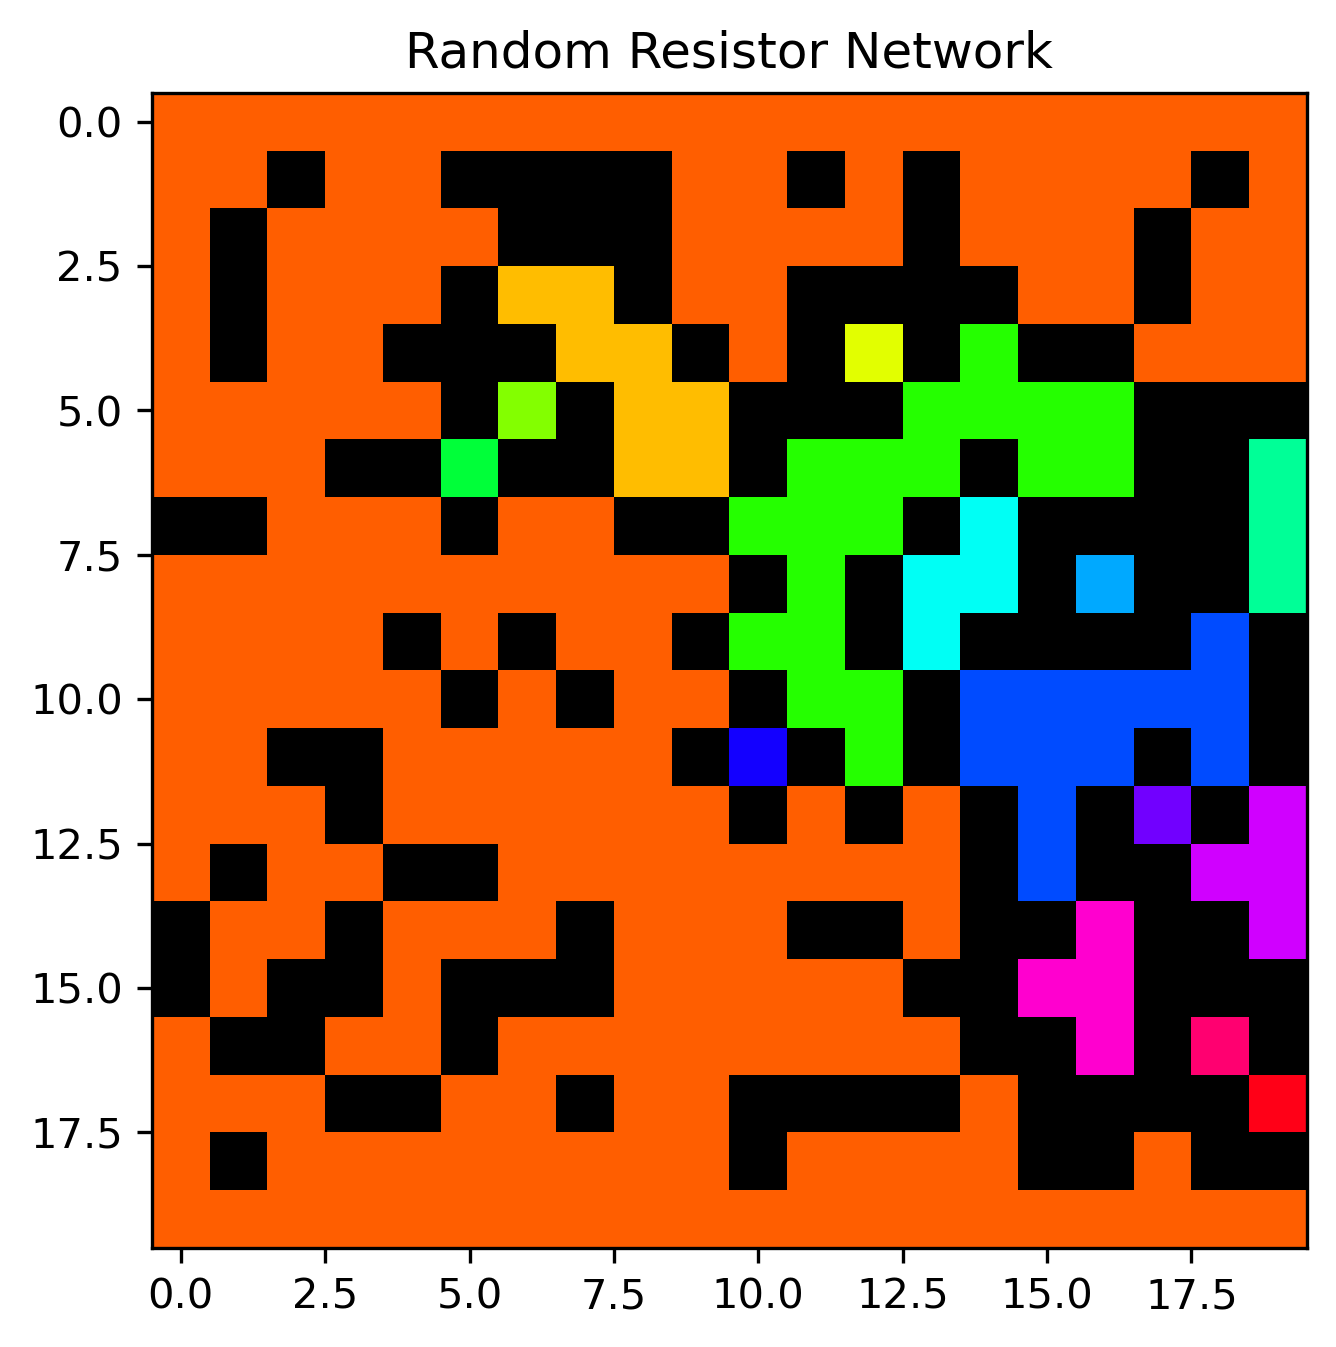

In [283]:
lattice = gen_and_plot(20, p=0.62)
conductivity = CalculateConductivity(lattice,1e4, 1e-5, 0.8,False) / CalculateConductivity(generate_percolation_lattice(40, 1),1e4, 1e-5, 0.8,False)
print("Conductivity of the sample lattice: " + str(conductivity))

$$V_{k+1}(x_i, y_j) = \frac{\sigma(x_i+1, y_j)V_k(x_i+1, y_j) + \sigma(x_i, y_j)V_k(x_i-1, y_j) + \sigma(x_i, y_j+1)V_k(x_i, y_j+1) + \sigma(x_i, y_j)V_k(x_i, y_j-1)}{\sigma(x_i+1, y_j) + \sigma(x_i, y_j+1) + 2\sigma(x_i, y_j)} $$ 

In [264]:
CalculateConductivity(generate_percolation_lattice(20, 0.7),1e4, 1e-5, 0.8,True)
CalculateConductivity(generate_percolation_lattice(20, 1),1e4, 1e-5, 0.8,True)

Converged after 69 iterations.
Total current at the top: 0.47358498683213945
Total current at the bottom: 0.47337302321937824
The total current at the top and bottom match within the tolerance.
Converged after 1 iterations.
Total current at the top: 1.0526315789473695
Total current at the bottom: 1.0526315789473686
The total current at the top and bottom match within the tolerance.


1.052631578947369

In [4]:
def monte_carlo_per_size(L, num_trials, tolerance):
    probabilities = np.zeros(num_trials)
    for i in range(num_trials):
        low = 0.0
        high = 1.0
        p = (high + low) / 2
        p_old = 0.0

        while np.abs(p_old - p) > tolerance:
            lattice = generate_percolation_lattice(L, p)
            labeling = hoshen_kopelman(L, lattice)
            if spanning_check(labeling):
                high = p
            else:
                low = p
            p_old = p
            p = (high + low) / 2

        probabilities[i] = p

    avg = np.mean(probabilities)
    stdev = np.std(probabilities)
    sem = np.std(probabilities) / np.sqrt(num_trials)
    return probabilities, avg, stdev, sem

def monte_carlo_multithreaded(sizes, num_trials, tolerance, num_workers=12): 
    results = []
    avg = np.zeros(len(sizes))
    stdev = np.zeros(len(sizes))
    sem = np.zeros(len(sizes))

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(monte_carlo_per_size, size, num_trials, tolerance): idx for idx, size in enumerate(sizes)}
        
        for future in as_completed(futures):
            idx = futures[future]
            probabilities, avg_val, stdev_val, sem_val = future.result()
            results.insert(idx, probabilities)
            avg[idx] = avg_val
            stdev[idx] = stdev_val
            sem[idx] = sem_val
    
    return np.array(results), np.array(avg), np.array(stdev), np.array(sem)

In [5]:
size_valsPC = np.linspace(10, 100, 10).round().astype(int)  # range of L
num_trialsPC = int(1e4)  # number of trials
tolerancePC = 1e-5
num_workersPC = 16  # Set number of workers (processes) to use

#resultsPC, avgPC, stdevPC, semPC = monte_carlo_multithreaded(size_valsPC, num_trialsPC, tolerancePC, num_workersPC)

In [6]:
#np.savez('mc_simulation_resultsPC.npz', size_valsPC=size_valsPC, avgPC=avgPC, stdevPC=stdevPC, semPC=semPC)

In [7]:
saved_data = np.load('mc_simulation_resultsPC.npz')
size_valsPC = saved_data['size_valsPC']
avgPC = saved_data['avgPC']
stdevPC = saved_data['stdevPC']
semPC = saved_data['semPC']

0.5922627075195313


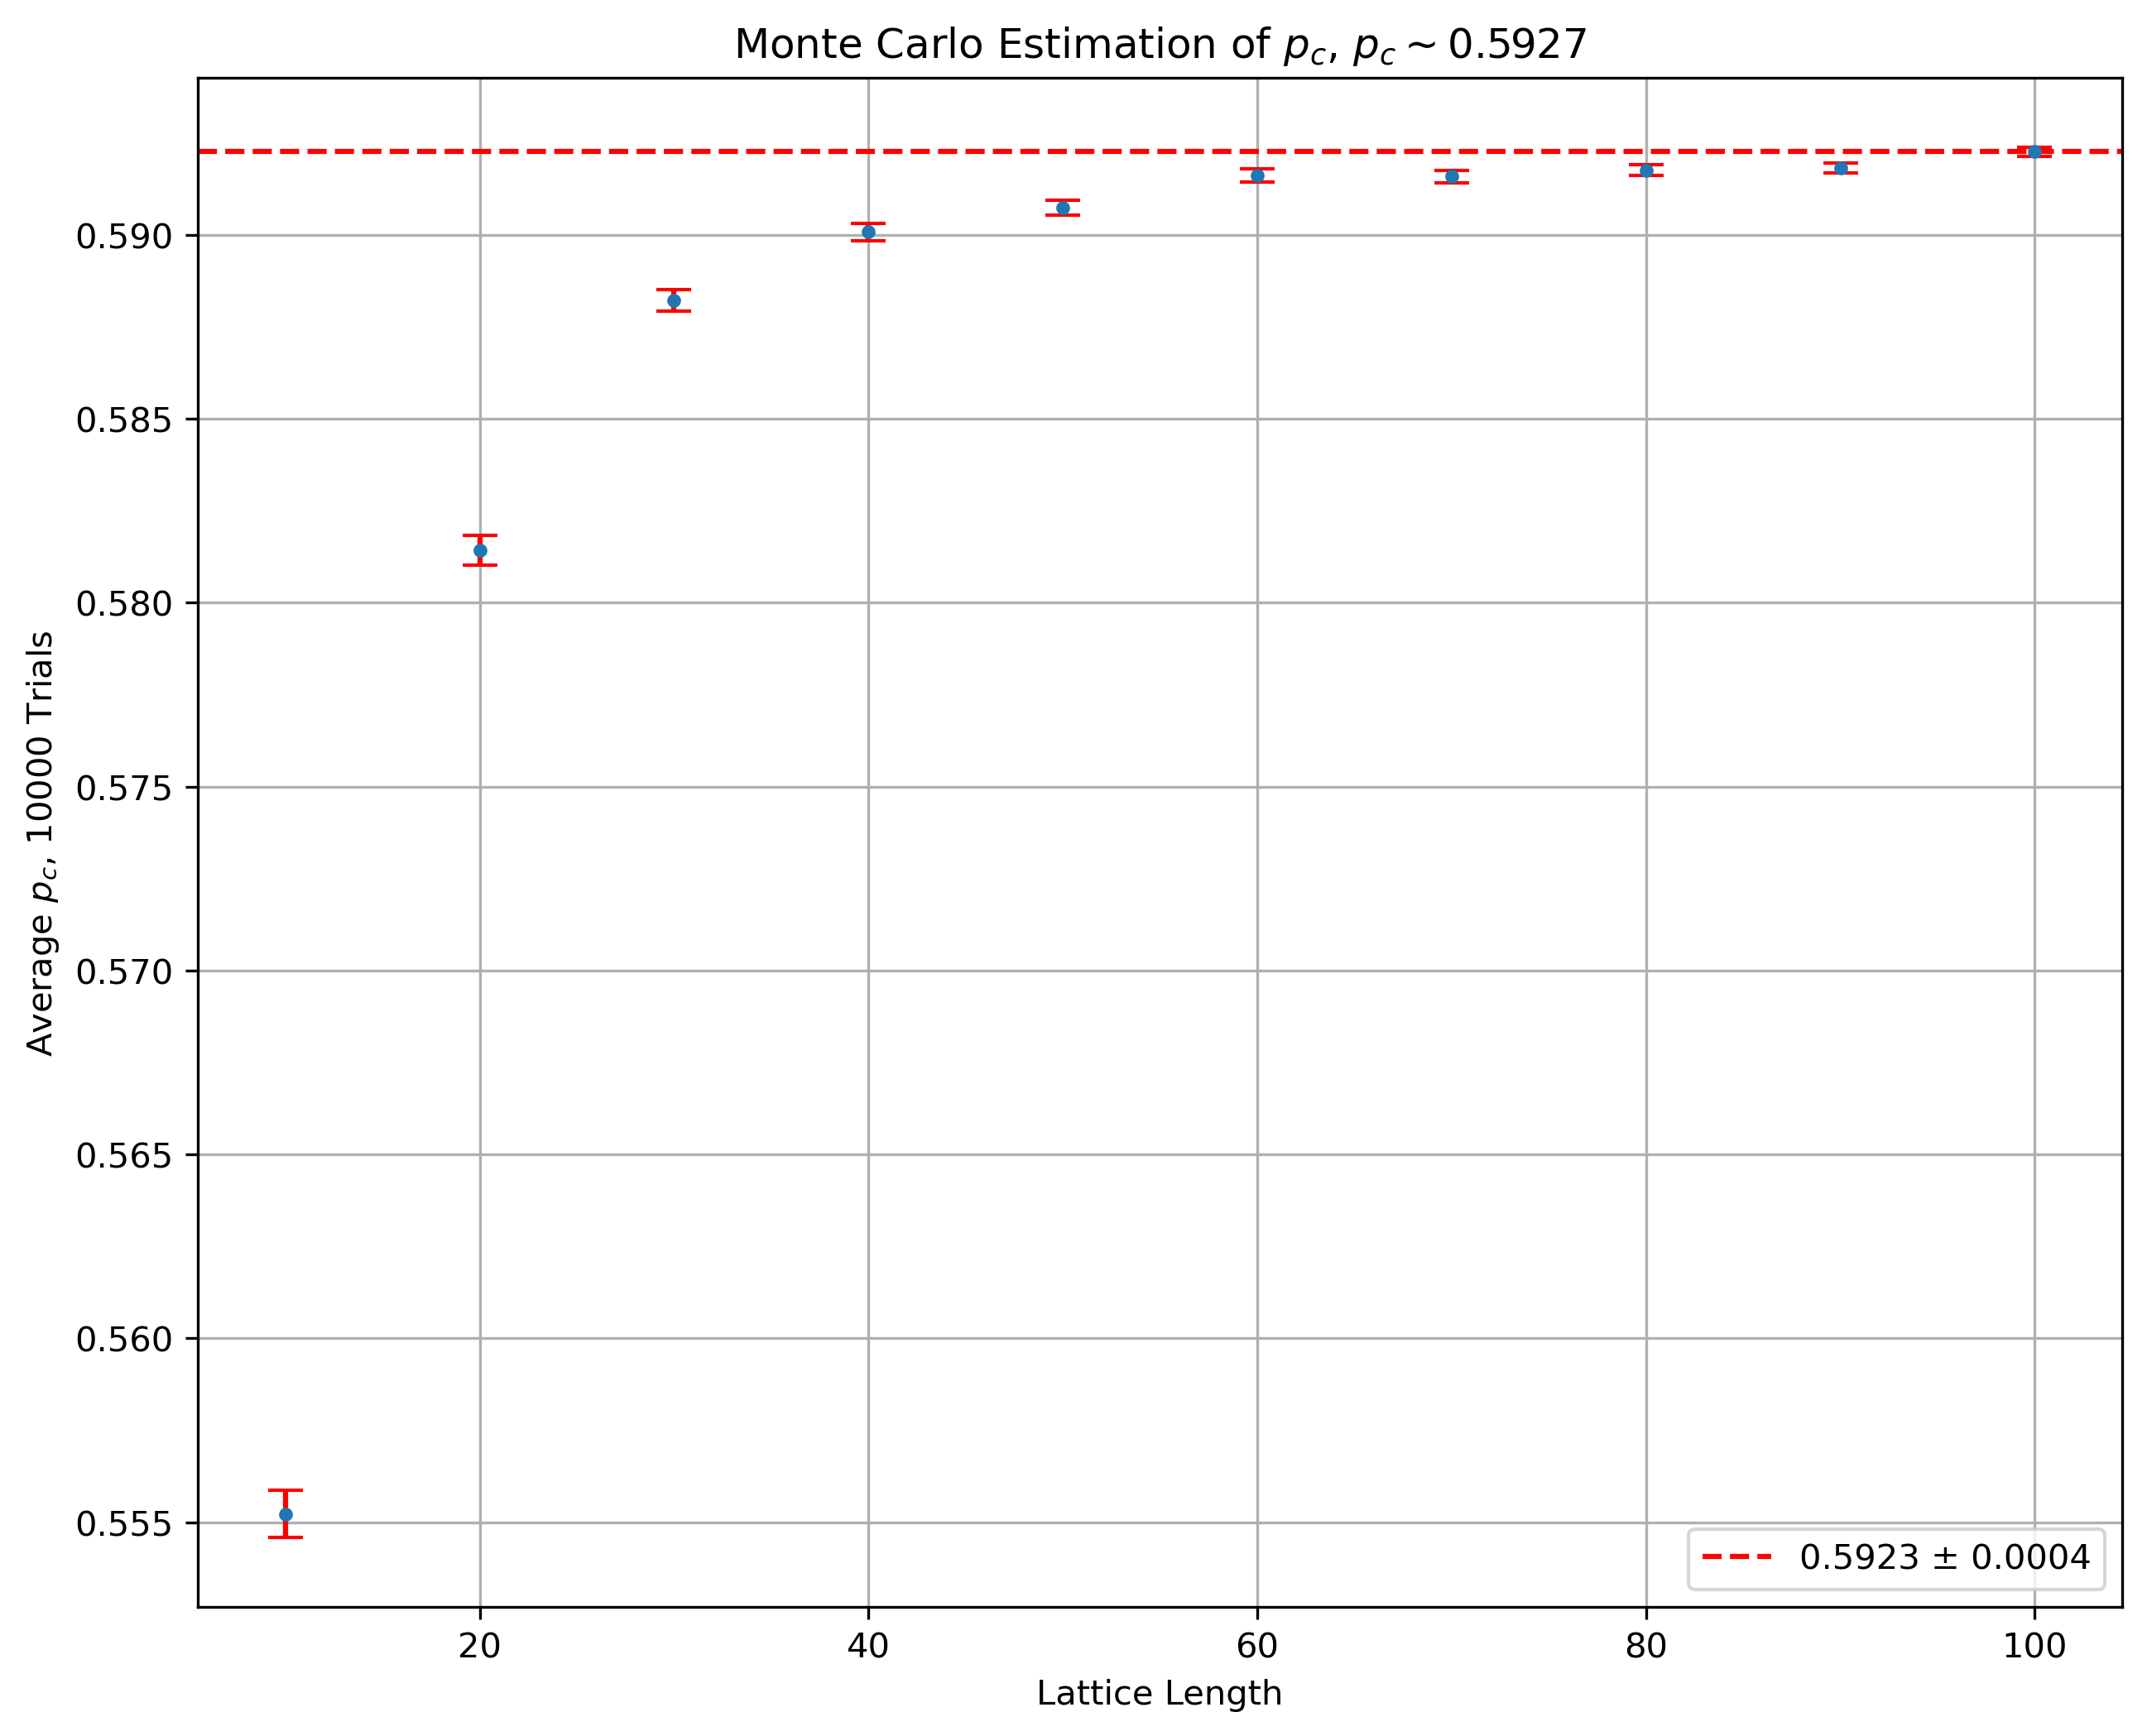

In [8]:
fig, ax = plt.subplots(figsize=(10, 8), dpi= 300, facecolor='w', edgecolor='k')
# Plot with different color for error bars
plt.errorbar(size_valsPC, avgPC, yerr=semPC, fmt='.', ecolor='red', capsize=5)

# Adding a horizontal line with value equal to the last element of avgPC
last_avgPC = avgPC[-1]
last_semPC = semPC[-1]
print(last_avgPC)
plt.axhline(last_avgPC, color='red', linestyle='--', label=f'{last_avgPC:.4f} ± {3*last_semPC:.4f}')

plt.xlabel('Lattice Length')
plt.ylabel(r'Average $p_c$, ' + str(num_trialsPC) + ' Trials')
plt.title(r'Monte Carlo Estimation of $p_c$, $p_c \sim 0.5927$')

# Optional: Customize the plot
plt.grid(True)
plt.legend()

plt.savefig('p_c.png')
# Display the plot
plt.show()


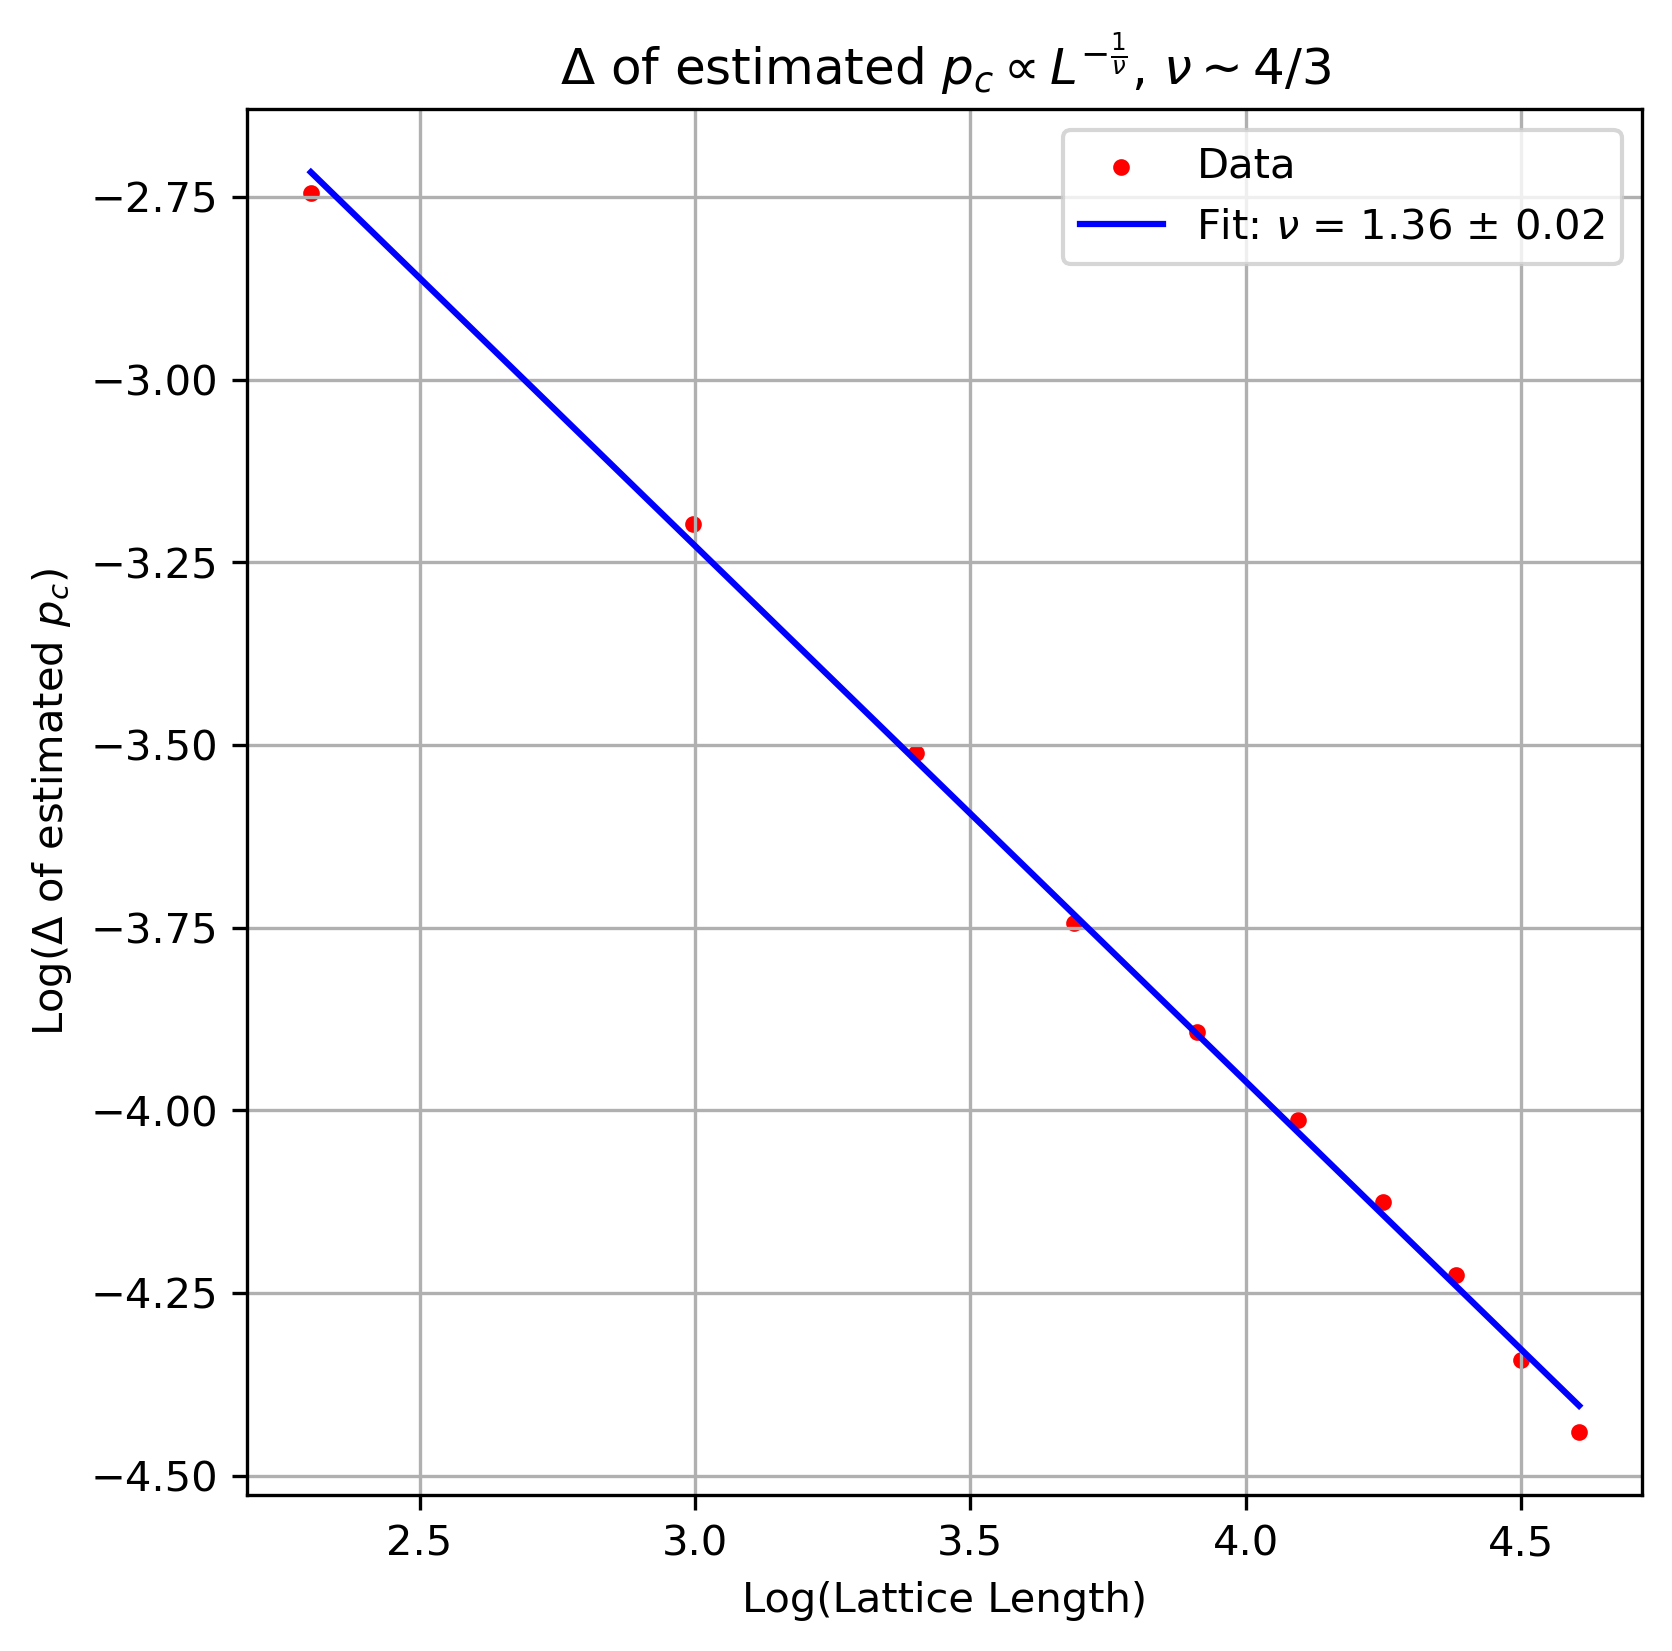

Slope of the log-log fit: -0.7331812598989016
nu: 1.3639192034693985
nu_error 0.019128424548233124


In [240]:
# Log-log plot
log_size_valsPC = np.log(size_valsPC)
log_stdevPC = np.log(stdevPC)

# Define linear function for curve fitting
def linear(x, a, b):
    return a * x + b

# Fit the data to the linear function
popt, pcov = curve_fit(linear, log_size_valsPC, log_stdevPC, p0=[-.7,1])
slope, intercept = popt
slope_err = np.sqrt(pcov[0, 0])  # Standard deviation of the slope


nu_err = slope_err / (slope ** 2)

# Plot log-log data and fitted line
fig, ax = plt.subplots(figsize=(6, 6), dpi=300, facecolor='w', edgecolor='k')
ax.scatter(log_size_valsPC, log_stdevPC, marker='.', color='red', label='Data')
ax.plot(log_size_valsPC, intercept + slope * log_size_valsPC, 'b', label=rf'Fit: $\nu$ = {-1/slope:.2f} ± {nu_err:.2f}')
ax.set_xlabel('Log(Lattice Length)')
ax.set_ylabel(r'Log($\Delta$ of estimated $p_c$)')
ax.set_title(r'$\Delta$ of estimated $p_c \propto L^{-\frac{1}{\nu}}$, $\nu \sim 4/3$')

# Optional: Customize the plot
ax.grid(True)
ax.legend()

plt.savefig('loglog_pc.png')
# Display the plot
plt.show()

print(f"Slope of the log-log fit: {slope}")
print(r"nu: " + str(-1/slope))
print("nu_error " + str(nu_err))

In [241]:
def conductivityMC(L, num_trials, verbose=True):

    norm_factor = CalculateConductivity(generate_percolation_lattice(L, 1), 1e4, 1e-5, 0.8, verbose)
    conductivities = [
        CalculateConductivity(generate_percolation_lattice(L, 0.592746), 1e4, 1e-5, 0.8, verbose) / norm_factor
        for _ in range(num_trials)
    ]
    
    avg = np.mean(conductivities)
    stdev = np.std(conductivities)
    sem = np.std(conductivities) / np.sqrt(num_trials)
    return conductivities, avg, stdev, sem

def multithreadedConductivityMC(sizes, num_trials, num_workers=16): 
    results = []
    avg = np.zeros(len(sizes))
    stdev = np.zeros(len(sizes))
    sem = np.zeros(len(sizes))

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(conductivityMC, size, num_trials, False): idx for idx, size in enumerate(sizes)}
        
        for future in as_completed(futures):
            idx = futures[future]
            probabilities, avg_val, stdev_val, sem_val = future.result()
            results.insert(idx, probabilities)
            avg[idx] = avg_val
            stdev[idx] = stdev_val
            sem[idx] = sem_val

    return np.array(results), np.array(avg), np.array(stdev), np.array(sem)

In [227]:
conductivityMC(10, 2, False)

([0.3573478801713933, 0.32126361307315754],
 0.3393057466222754,
 0.018042133549117878,
 0.012757714979654562)

In [254]:
size_valsC = np.arange(3, 12)
num_trialsC = int(1e4)  # number of trials

resultsC, avgC, stdevC, semC = multithreadedConductivityMC(size_valsC, num_trialsC)

In [255]:
print(size_valsC)

[ 3  4  5  6  7  8  9 10 11]


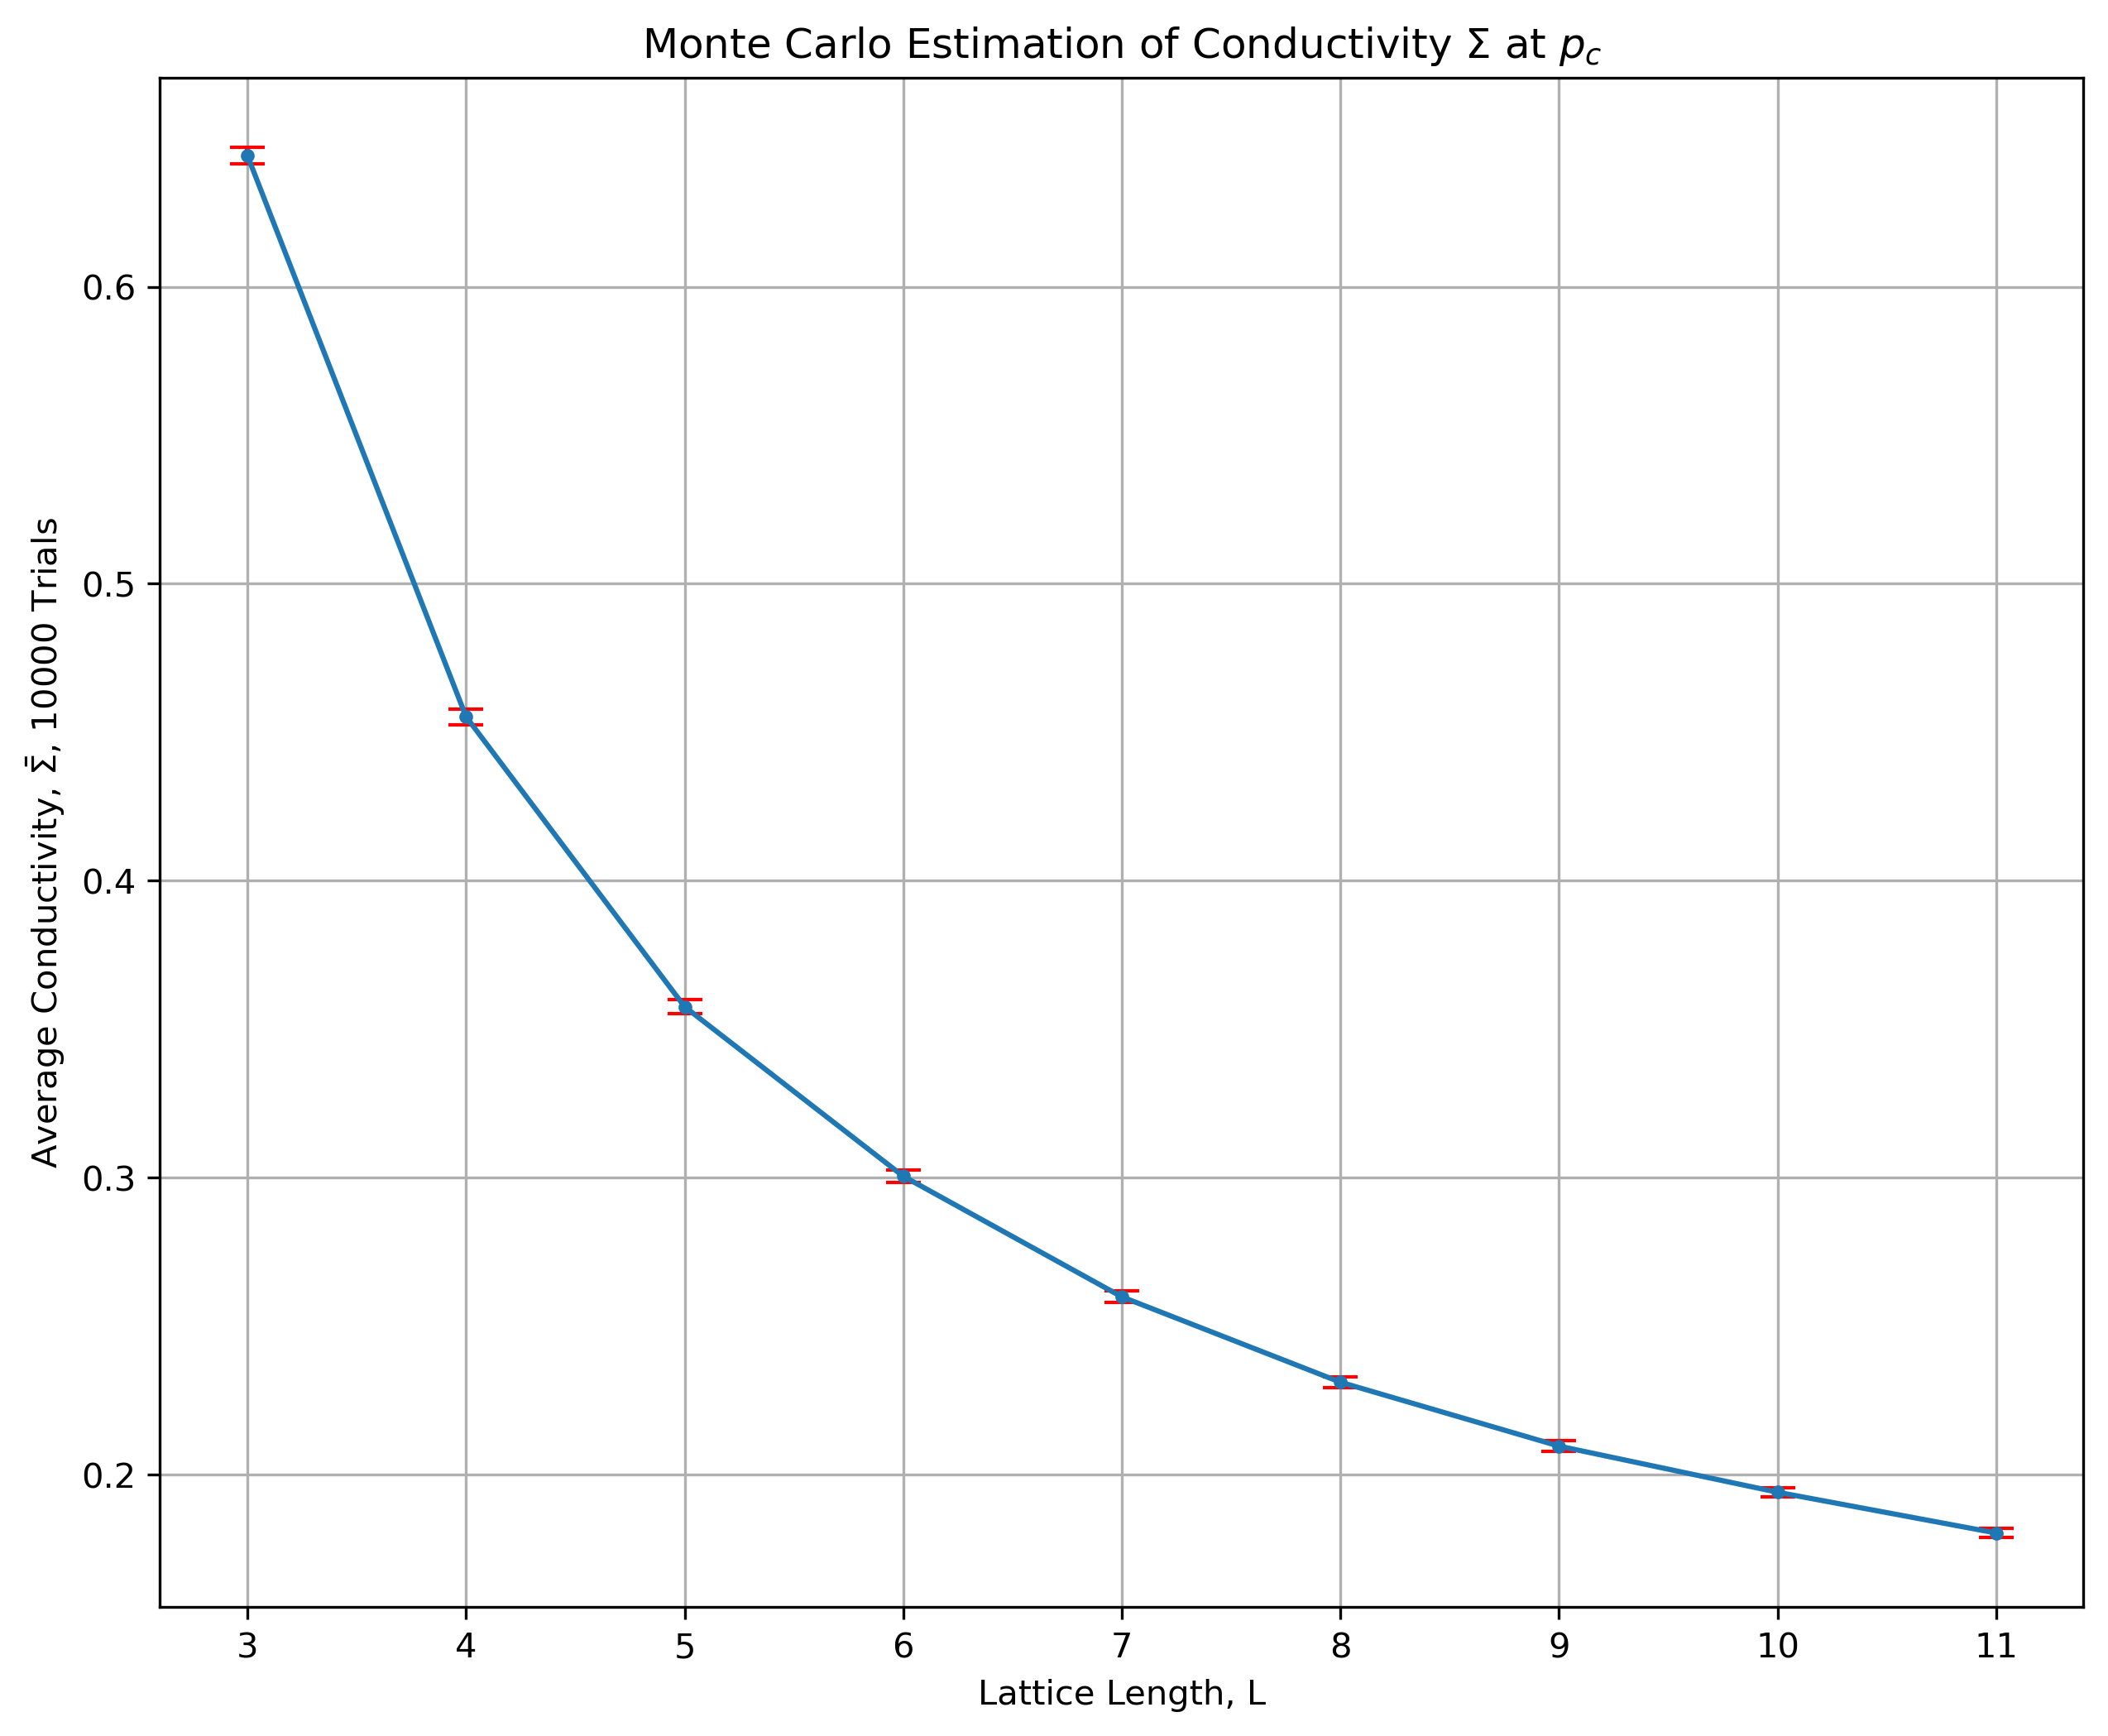

In [256]:
fig, ax = plt.subplots(figsize=(10, 8), dpi= 300, facecolor='w', edgecolor='k')
# Plot with different color for error bars
plt.errorbar(size_valsC, avgC, yerr=semC, capsize=5, fmt='.-', ecolor='red')
plt.xlabel('Lattice Length, L')
plt.ylabel(r'Average Conductivity, $\bar{\Sigma}$, ' + str(num_trialsC) + ' Trials')
plt.title(r'Monte Carlo Estimation of Conductivity $\Sigma$ at $p_c$')
plt.grid(True)

plt.savefig('c.png')
# Display the plot
plt.show()


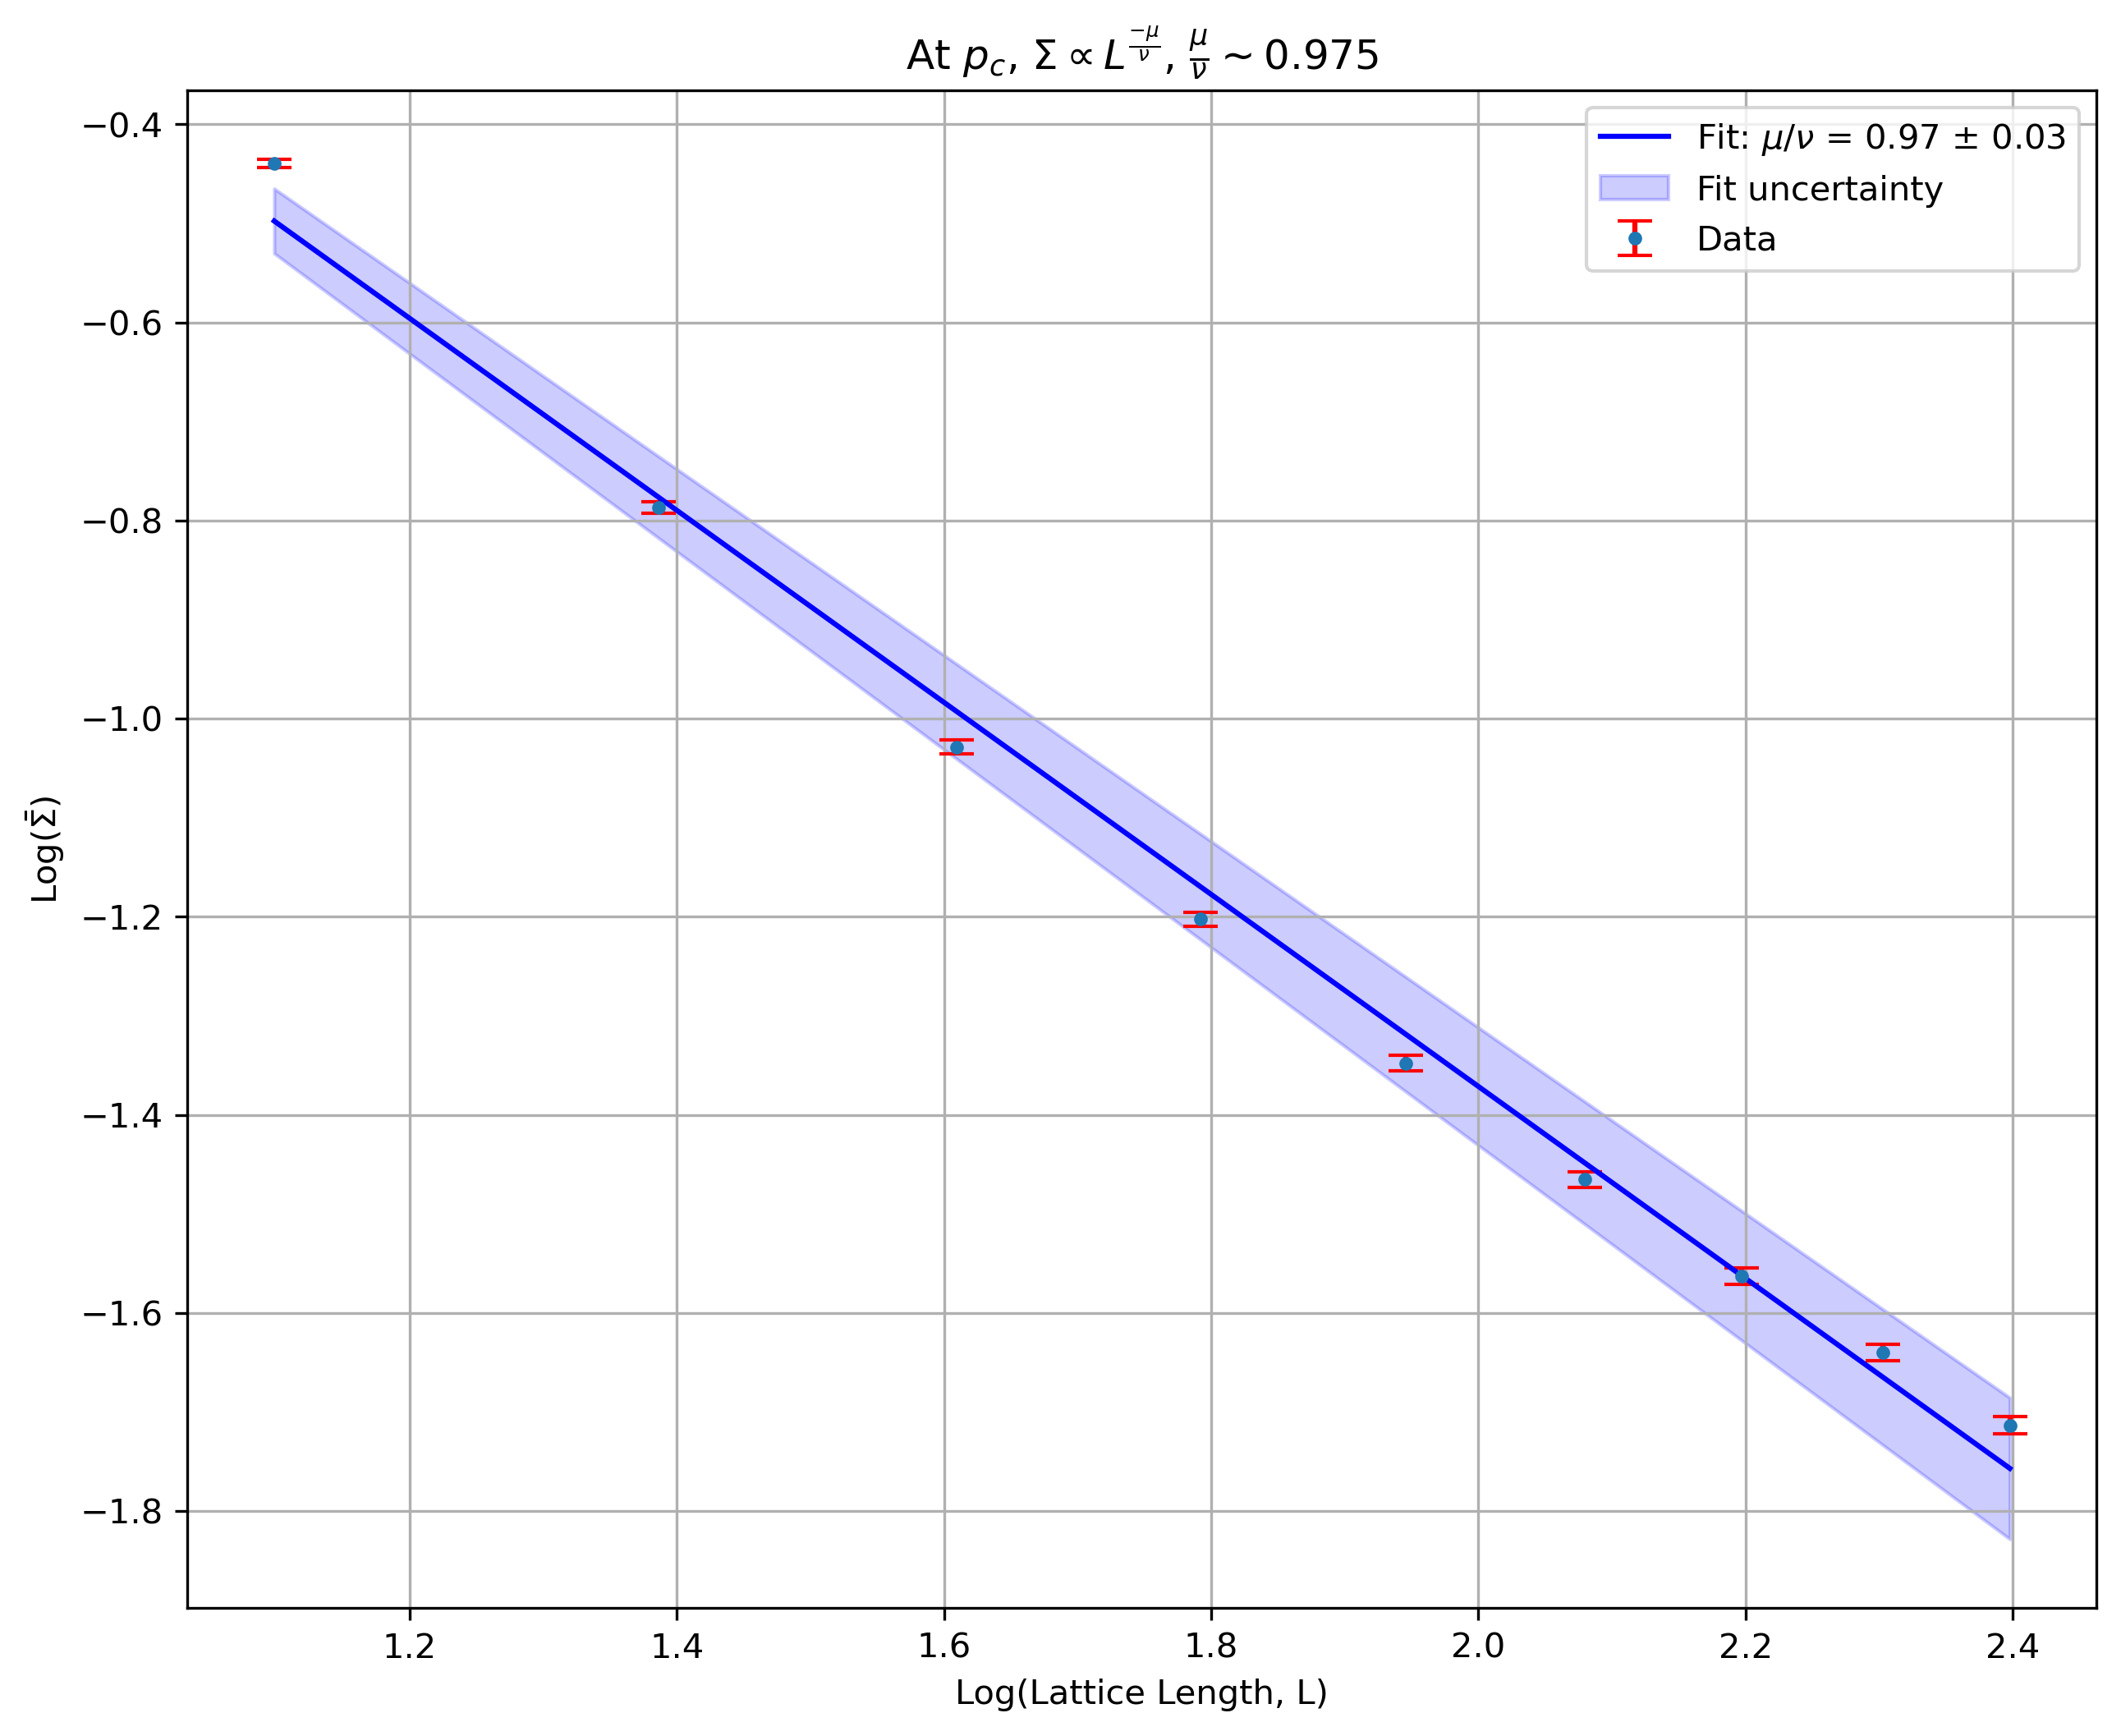

Slope of the log-log fit: -0.969 ± 0.030


In [257]:
# Provided data
log_size_valsC = np.log(size_valsC)
log_avgC = np.log(avgC)

# Fit the data to the linear function
popt, pcov = curve_fit(linear, log_size_valsC, log_avgC, p0=[-0.975, 1])
slope, intercept = popt
slope_err = np.sqrt(pcov[0, 0])  # Standard deviation of the slope

# Plot log-log data and fitted line
fig, ax = plt.subplots(figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
ax.errorbar(log_size_valsC, log_avgC, yerr=semC/avgC, fmt='.', ecolor='red', capsize=5, label='Data')

# Fit line
fit_line = intercept + slope * log_size_valsC
ax.plot(log_size_valsC, fit_line, 'b', label=rf'Fit: $\mu/\nu$ = {-slope:.2f} ± {slope_err:.2f}')

# Upper and lower bounds for the error region
upper_bound = intercept + (slope + slope_err) * log_size_valsC
lower_bound = intercept + (slope - slope_err) * log_size_valsC

# Fill area between the bounds
ax.fill_between(log_size_valsC, lower_bound, upper_bound, color='blue', alpha=0.2, label='Fit uncertainty')

ax.set_xlabel('Log(Lattice Length, L)')
ax.set_ylabel(r'Log($\bar{\Sigma}$)')
ax.set_title(r'At $p_c$, $\Sigma \propto L^{\frac{-\mu}{\nu}}$, $\frac{\mu}{\nu} \sim 0.975$')

# Optional: Customize the plot
ax.grid(True)
ax.legend()

# Save and display the plot
plt.savefig('loglog_c.png')
plt.show()

# Print the slope with its error
print(f"Slope of the log-log fit: {slope:.3f} ± {slope_err:.3f}")

In [160]:
def conductivity_and_mass_MC(L, prob, num_trials, verbose=False):
    norm_factor_cond = CalculateConductivity(generate_percolation_lattice(L, 1), 1e4, 1e-3, 0.7, verbose)
    lattice = generate_percolation_lattice(L, 1)
    labeling = hoshen_kopelman(lattice)
    spanning, span_label = spanning_check(labeling)
    norm_factor_mass = calculate_mass(lattice, labeling, span_label)

    conductivities = []
    masses = []
    
    for _ in range(num_trials):
        lattice = generate_percolation_lattice(L, prob)
        labeling = hoshen_kopelman(lattice)
        spanning, span_label = spanning_check(labeling)
        
        if spanning:
            mass = calculate_mass(lattice, labeling, span_label) / norm_factor_mass
            conductivity = CalculateConductivity(lattice, 1e4, 1e-3, 0.8, False) / norm_factor_cond
    
        else:
            mass = 0
            conductivity=0
        
        conductivities.append(conductivity)
        masses.append(mass)

    avg_conductivity = np.mean(conductivities)
    stdev_conductivity = np.std(conductivities)
    sem_conductivity = np.std(conductivities) / np.sqrt(num_trials)
    
    avg_mass = np.mean(masses)
    stdev_mass = np.std(masses)
    sem_mass = np.std(masses) / np.sqrt(num_trials)
    
    return conductivities, masses, avg_conductivity, stdev_conductivity, sem_conductivity, avg_mass, stdev_mass, sem_mass

def multithreadedConductivityAndMassMC(probs, num_trials, num_workers=16):
    results_conductivities = []
    results_masses = []

    avg_conductivity = np.zeros(len(probs))
    stdev_conductivity = np.zeros(len(probs))
    sem_conductivity = np.zeros(len(probs))

    avg_mass = np.zeros(len(probs))
    stdev_mass = np.zeros(len(probs))
    sem_mass = np.zeros(len(probs))
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(conductivity_and_mass_MC, 40, prob, num_trials, False): idx for idx, prob in enumerate(probs)}
        for future in as_completed(futures):
            idx = futures[future]
            conductivities, masses, avg_cond, stdev_cond, sem_cond, avg_m, stdev_m, sem_m = future.result()
            results_conductivities.insert(idx, conductivities)
            avg_conductivity[idx] = avg_cond
            stdev_conductivity[idx] = stdev_cond
            sem_conductivity[idx] = sem_cond
            results_masses.insert(idx, masses)
            avg_mass[idx] = avg_m
            stdev_mass[idx] = stdev_m
            sem_mass[idx] = sem_m

    return results_conductivities, avg_conductivity, stdev_conductivity, sem_conductivity, results_masses, avg_mass, stdev_mass, sem_mass

In [258]:
probs = np.linspace(0.592, 1, 250)
num_trials = int(5e2)  # Number of Monte Carlo trials for each probability
num_workers = 16  # Number of worker threads

# Run the Monte Carlo simulations in parallel
results_conductivities, avg_conductivity, stdev_conductivity, sem_conductivity, results_masses, avg_mass, stdev_mass, sem_mass = multithreadedConductivityAndMassMC(probs, num_trials, num_workers)

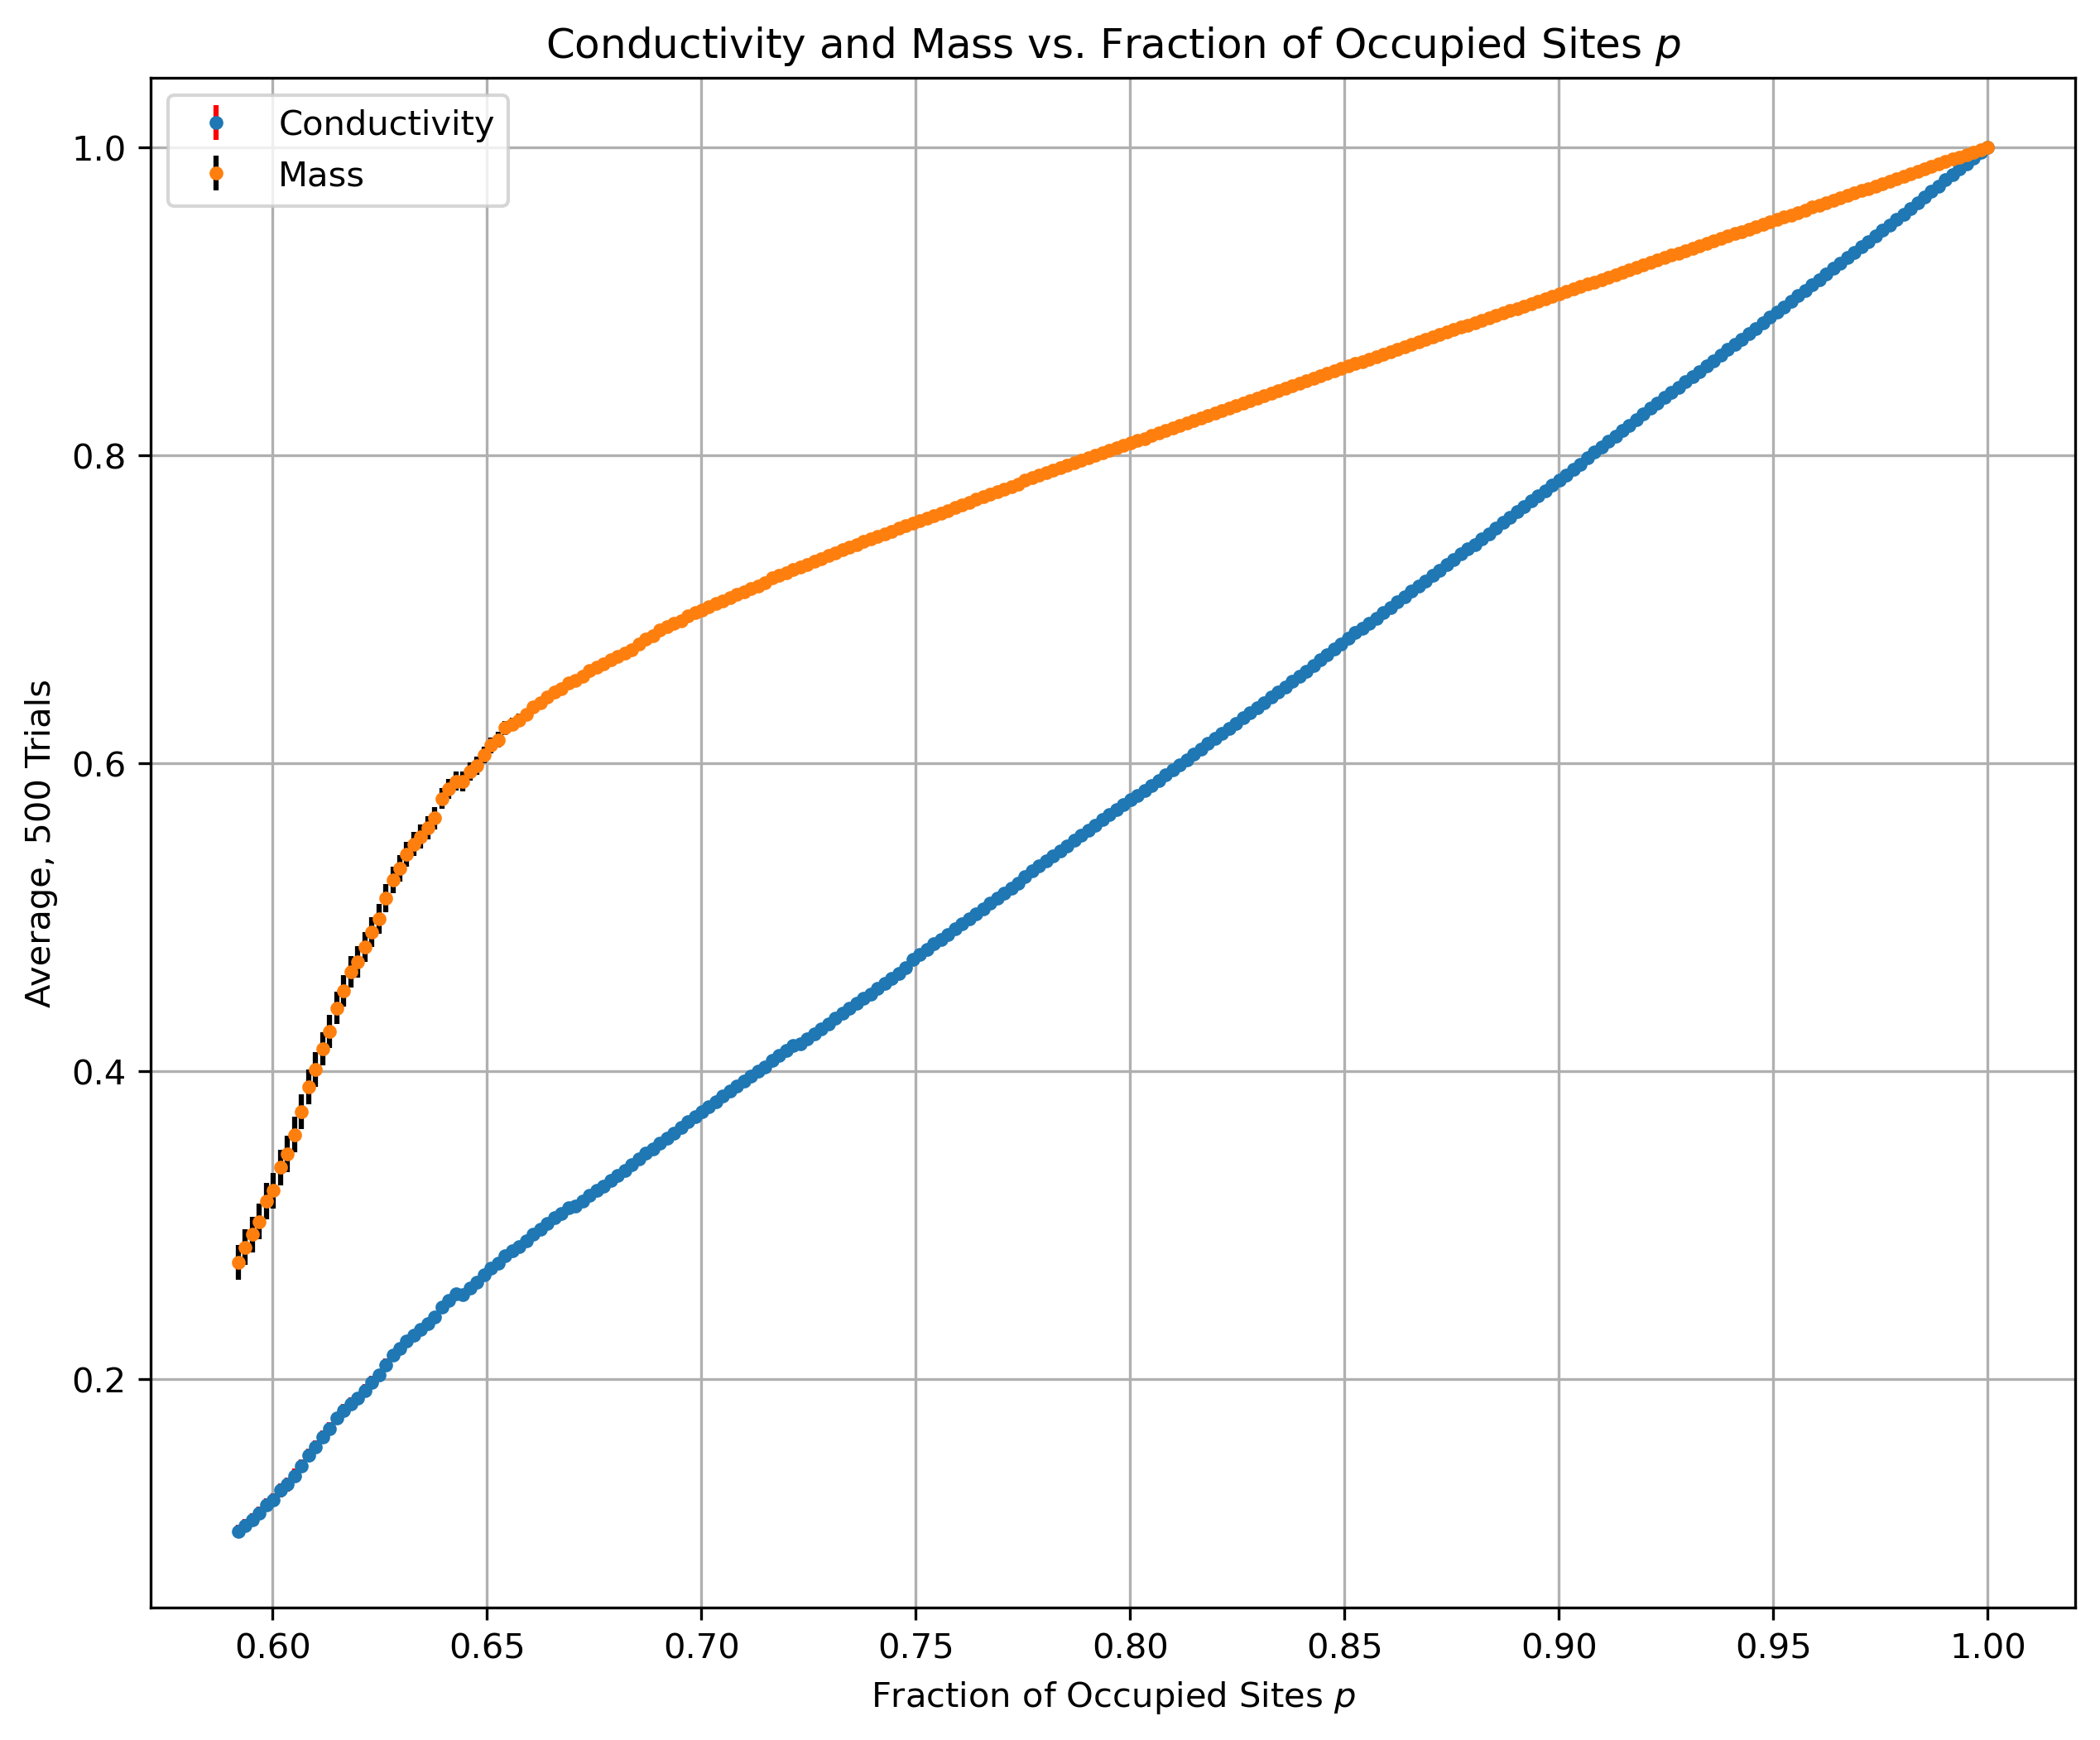

In [259]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plt.errorbar(probs, avg_conductivity, yerr=sem_conductivity, fmt='.', ecolor='red', label='Conductivity')
plt.errorbar(probs, avg_mass, yerr=sem_mass, fmt='.', ecolor='black', label='Mass')
plt.xlabel('Fraction of Occupied Sites $p$')
plt.ylabel(r'Average, ' + str(num_trials) + ' Trials')
plt.title(r'Conductivity and Mass vs. Fraction of Occupied Sites $p$')

# Optional: Customize the plot
plt.grid(True)
plt.legend()

plt.savefig('conductivitymass.png')
# Display the plot
plt.show()

In [158]:
def CalculatePotentialSlowdown(network, maxiter, tolerance, alpha=0.8, verbose=True): 
    V_c = 1.0  # Define a constant potential
    potential = np.zeros(network.shape)
    size = network.shape[0]

    # Initialize the potential
    for row in np.arange(0, size):
        for column in np.arange(0, size):
            potential[row][column] = V_c * (size - row - 1) / (size - 1)

    numiter = 0
    reachedmax = True

    while numiter < maxiter:
        oldpotential = potential.copy()

        for row in np.arange(1, size-1):
            for column in np.arange(0, size):
                # Determine the neighboring column indices with periodic boundary conditions
                column_prev = (column - 1) % size
                column_next = (column + 1) % size

                if network[row][column] == 1:
                    sigmaxy = 1
                else:
                    sigmaxy = 0

                if network[row + 1][column] == 1:
                    sigmay1 = 1
                else:
                    sigmay1 = 0

                if network[row][column_next] == 1:
                    sigmax1 = 1
                else:
                    sigmax1 = 0

                sumsigma = sigmax1 + sigmay1 + 2 * sigmaxy
                if sumsigma == 0:
                    continue

                new_value = (
                    sigmax1 * potential[row, column_next] +
                    sigmaxy * potential[row, column_prev] +
                    sigmay1 * potential[row + 1, column] +
                    sigmaxy * potential[row - 1, column]
                ) / sumsigma
                
                potential[row][column] = (1 + alpha) * new_value - alpha * oldpotential[row][column]

        numiter += 1

        # Check the maximum delta
        delta_max = np.max(np.abs(oldpotential - potential))
        if delta_max < tolerance:
            if verbose:
                print("Converged after " + str(numiter) + " iterations.")
            reachedmax = False
            break

    if reachedmax:
        if verbose:
            print("Failed to converge, maximum number of iterations reached.")
    
    return potential, numiter

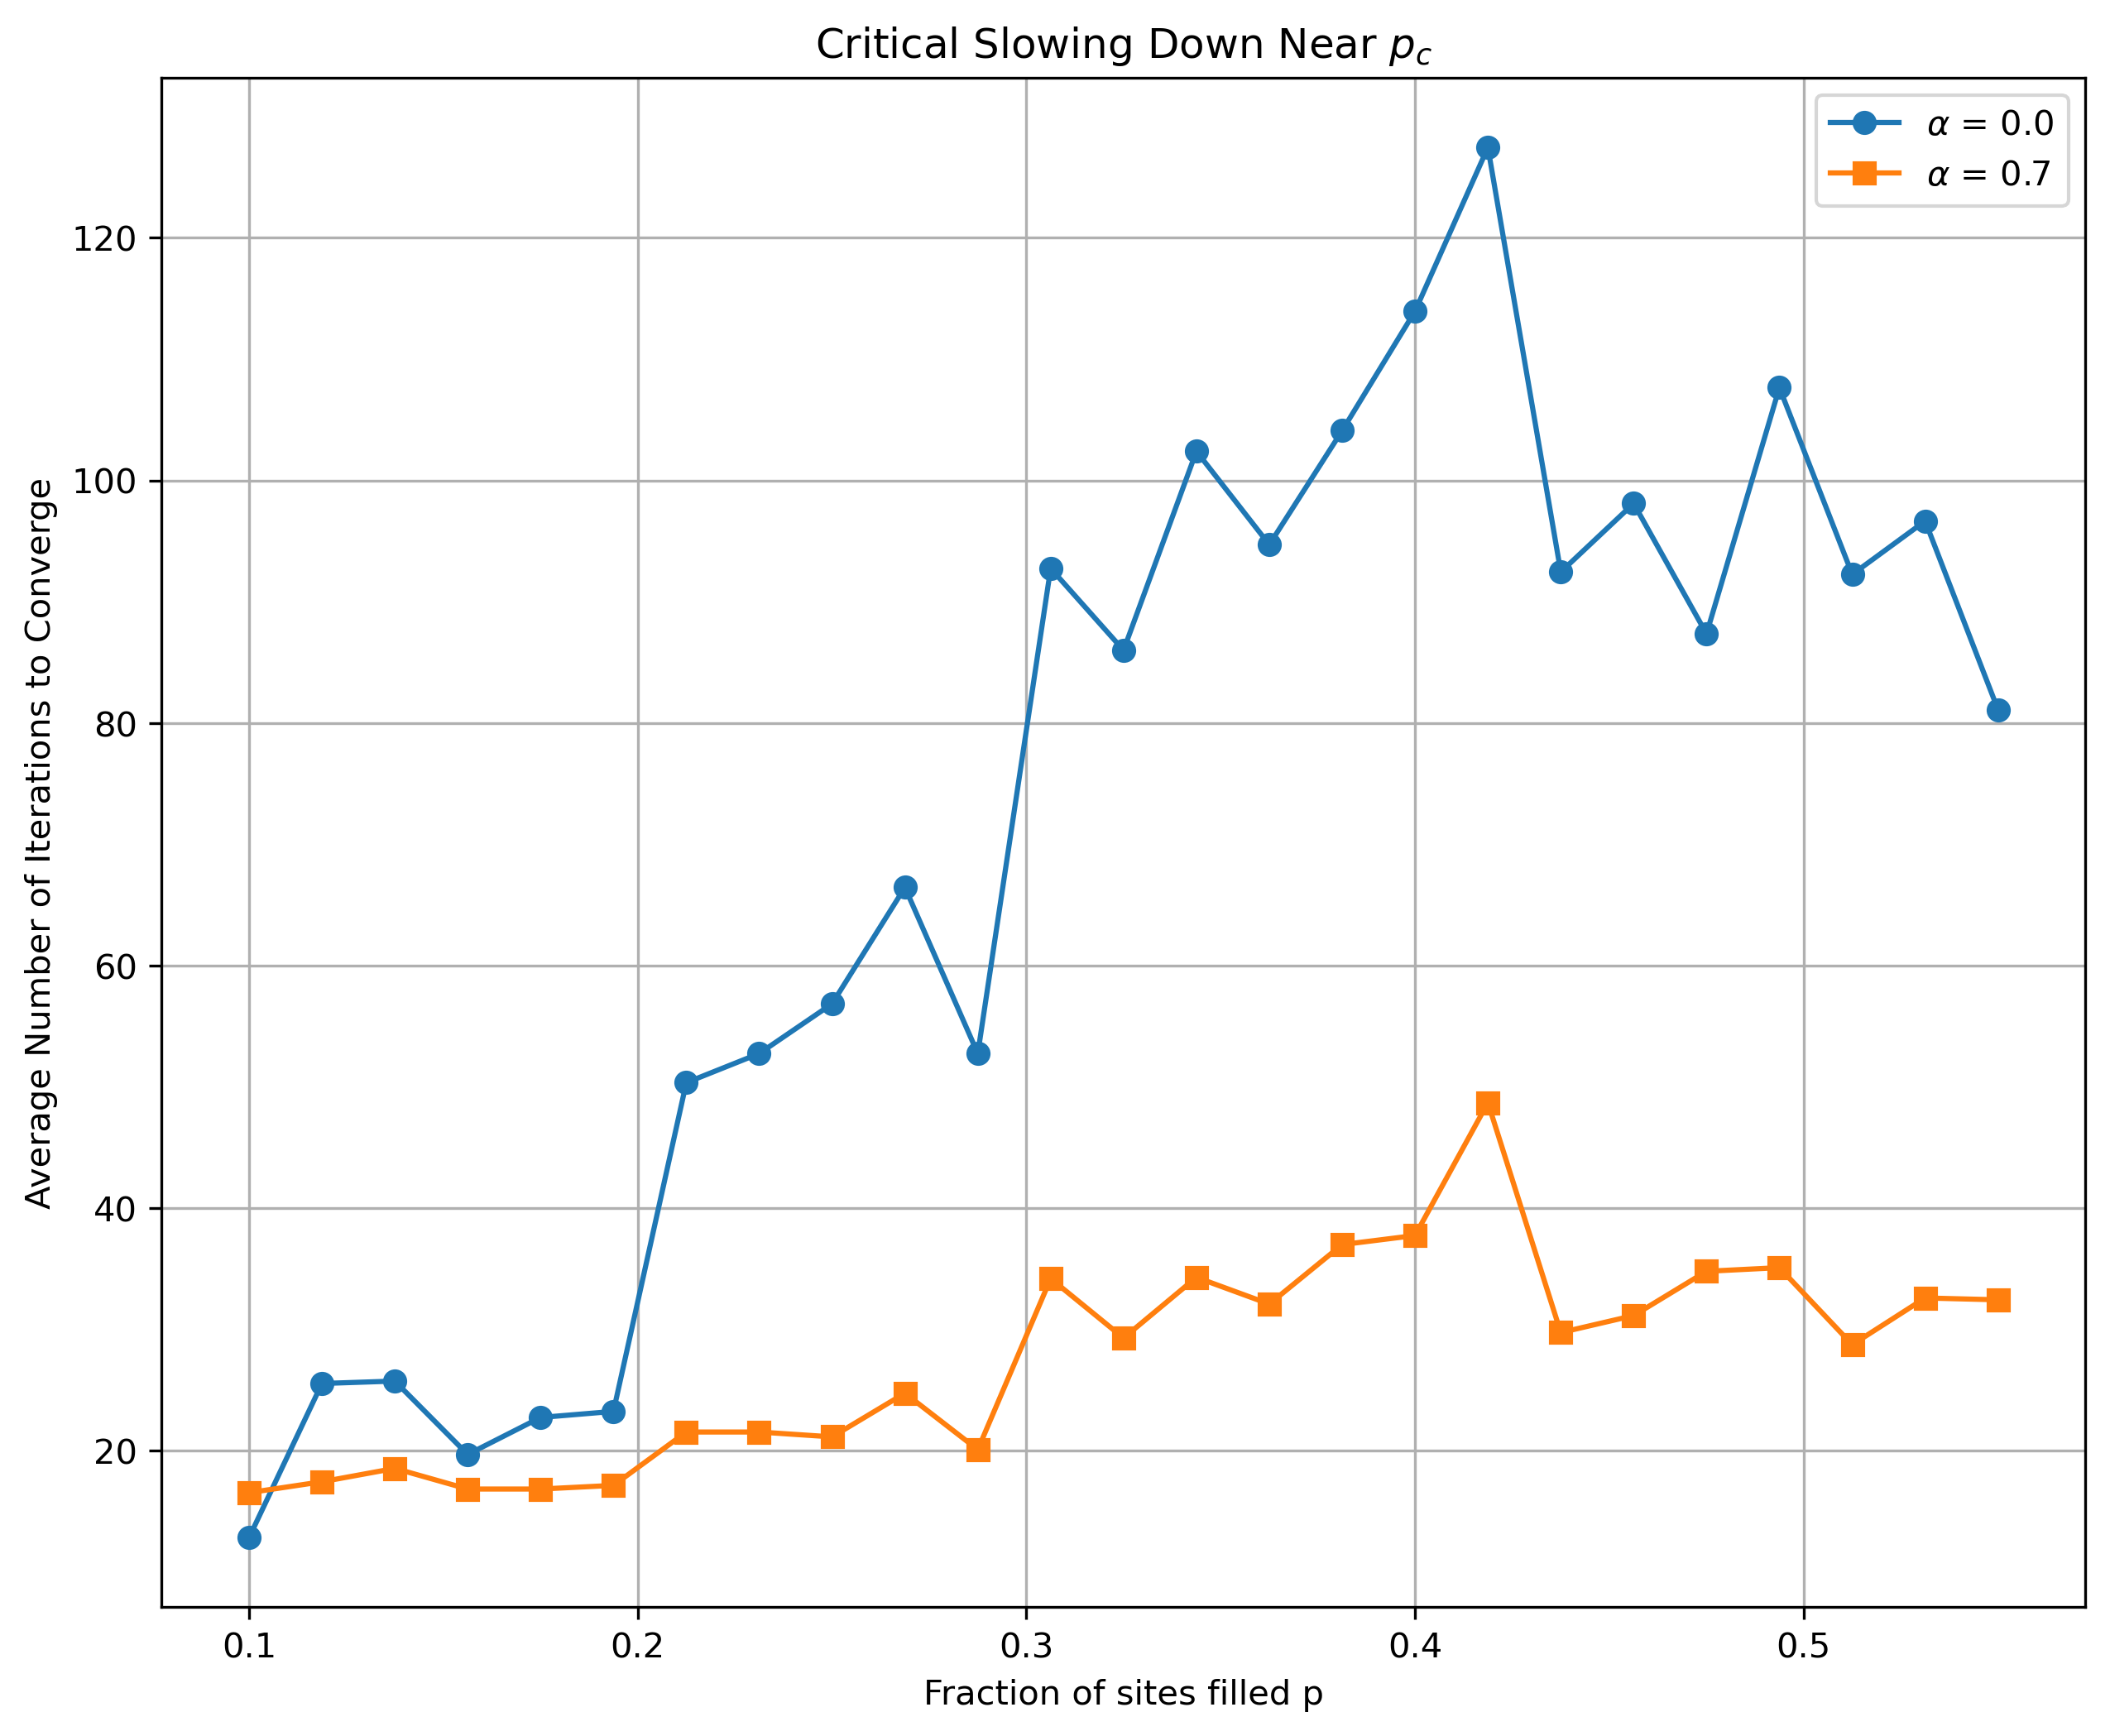

In [20]:
# Parameters
size = 10
maxiter = 1000
tolerance = 1e-3
num_trials = 20

probabilities = np.linspace(0.1, 0.55, 25)
avg_iterations_to_converge_alpha_0 = []
avg_iterations_to_converge_alpha_07 = []

for p in probabilities:
    iter_counts_alpha_0 = []
    iter_counts_alpha_07 = []
    for _ in range(num_trials):
        network = generate_percolation_lattice(size, p)
        
        # Alpha = 0
        _, num_iter_alpha_0 = CalculatePotentialSlowdown(network, maxiter, tolerance, alpha=0.0, verbose=False)
        iter_counts_alpha_0.append(num_iter_alpha_0)
        
        # Alpha = 0.7
        _, num_iter_alpha_07 = CalculatePotentialSlowdown(network, maxiter, tolerance, alpha=0.7, verbose=False)
        iter_counts_alpha_07.append(num_iter_alpha_07)
    
    avg_iterations_to_converge_alpha_0.append(np.mean(iter_counts_alpha_0))
    avg_iterations_to_converge_alpha_07.append(np.mean(iter_counts_alpha_07))

# Plotting
fig, ax = plt.subplots(figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
plt.plot(probabilities, avg_iterations_to_converge_alpha_0, marker='o', label=r'$\alpha$ = 0.0')
plt.plot(probabilities, avg_iterations_to_converge_alpha_07, marker='s', label=r'$\alpha$ = 0.7')
plt.xlabel('Fraction of sites filled p')
plt.ylabel('Average Number of Iterations to Converge')
plt.title('Critical Slowing Down Near $p_c$')
plt.legend()
plt.grid(True)
plt.savefig('slowdown.png')
plt.show()